# Hierarchical Clustering in GenePattern Notebook

Cluster genes and/or samples based on how close they are to one another. The result is a tree structure, referred to as dendrogram. This is an agglomerative (bottom up) form of hierarchical clustering.

## Before you begin

* Sign in to GenePattern by entering your username and password into the form below.
* Gene expression data must be in a [GCT or RES file](https://genepattern.broadinstitute.org/gp/pages/protocols/GctResFiles.html) - we have provided files in the correct format.
    * Example file: [all_aml_test.gct](https://software.broadinstitute.org/cancer/software/genepattern/data/all_aml/all_aml_test.gct).
* Learn more by reading about [file formats](http://www.broadinstitute.org/cancer/software/genepattern/file-formats-guide#GCT).


In [4]:
# Requires GenePattern Notebook: pip install genepattern-notebook
import gp
import genepattern

# Username and password removed for security reasons.
genepattern.display(genepattern.session.register("https://cloud.genepattern.org/gp", "", ""))

GPAuthWidget()

## 1. Understand distance metrics
- The illustration below illuminates the difference between two common distance metrics, the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the [Pearson distance](https://en.wikipedia.org/wiki/Distance_correlation).
- It uses four signals and then compares each one to the others, computing the Euclidean and Pearson distances.
- The Pearson distance has a minimum of 0 (no distance = signals are identical) and a maximum of 2 (the signals are maximally opposite each other).
- The Euclidean distance also has a minimum of 0, but because it corresponds to the geometric distance and not a statistical correlation, there is no bound on the maximum distance between two signals.

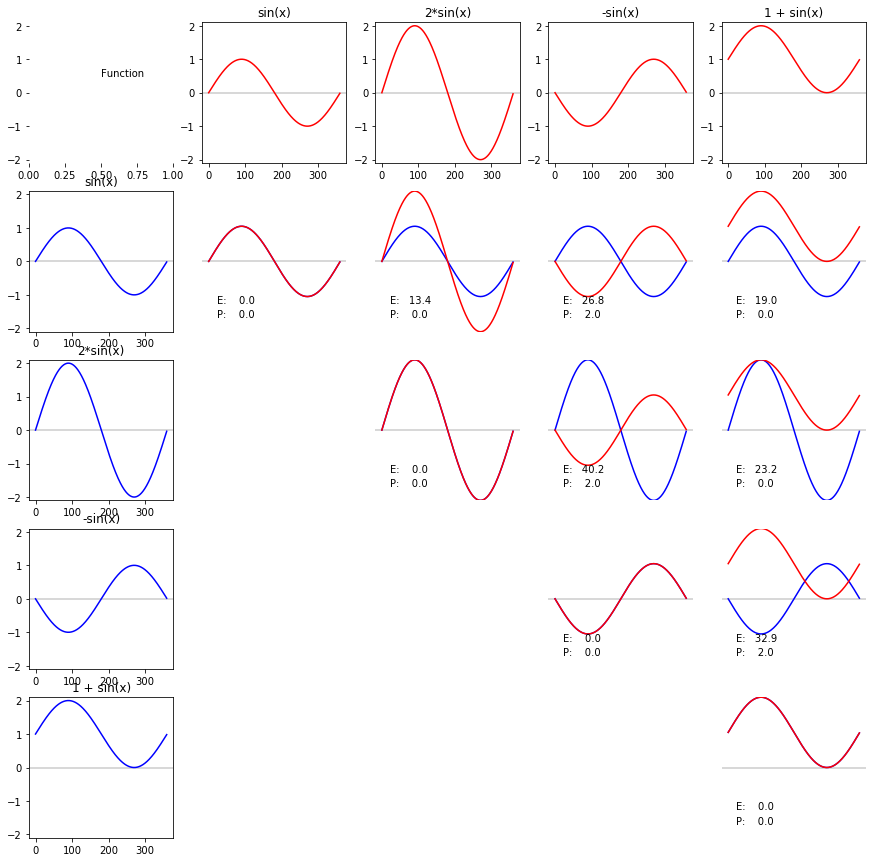

### Distance Metric Code

**Extra Credit:** You can reproduce the above image by running the code below.

<div class="alert alert-info">
<h3 style="margin-top: 0;"> Instructions <i class="fa fa-info-circle"></i></h3>
<ul>
	<li>Execute the following cell and view the distance metric plots.</li>
</ul>

<h4 id="Questions">Questions</h4>

<ul>
	<li>What pairings of signals produce &quot;closer&quot; distances?</li>
	<li>What types of signal are invariant under the Pearson distance?</li>
	<li>How does this compare with the Euclidean distance?</li>
</ul>
</div>

In [ ]:
%matplotlib inline

import scipy.stats as ss
import matplotlib.pyplot as plt
import math
import numpy as np
 
# Create series consisting of 360 points in degrees and radians:
deg360 = range(0,360)
circle2pi = np.arange(0,2*math.pi, 2*math.pi/360)
deg2rad = 2*math.pi/360

# Function for computing Euclidean distance between two vectors:
def euclidean(v1, v2):
    distance = math.sqrt(sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))
    return(distance)

# Class for representing signals (e.g., gene expression profiles) that will be compared:
class Signal():
    def __init__(self, name, func):
        self.name = name
        self.func = func

# Example signals:
sine_plain = Signal("sin(x)", [math.sin(x * deg2rad) for x in deg360])
sine_amp2 = Signal("2*sin(x)", [2*math.sin(x * deg2rad) for x in deg360])
sine_amp_1 = Signal("-sin(x)", [math.sin(-x * deg2rad) for x in deg360])
sine_plus_1 = Signal("1 + sin(x)", [math.sin(x * deg2rad) + 1 for x in deg360])

functions = [sine_plain, sine_amp2, sine_amp_1, sine_plus_1]

#
# Plot signals versus one another, along with computed distances
#

fig = plt.figure(figsize=(15,15))
num_funcs = len(functions)
grid_size = num_funcs + 1
axis_color = (.8,.8,.8)
axes = []

#Draw upper left-hand subplot:
ax = fig.add_subplot(grid_size, grid_size, 1)
ax.axis(ymin=-2.1, ymax=2.1)
axes.append(ax)
ax.set_frame_on(False)
ax.text(0.5,0.5,"Function")

# Draw single signals across the axes:
for f in range(num_funcs):
    ax = fig.add_subplot(grid_size,grid_size,((f+1)*(grid_size)+ 1))
    ax.axis(ymin=-2.1, ymax=2.1)
    plt.title(functions[f].name)
    axes.append(ax)
    ax.axhline(color=axis_color)
    ax.plot(deg360, functions[f].func, 'b')

    ax = fig.add_subplot(grid_size,grid_size,(f+2))
    ax.axis(ymin=-2.1, ymax=2.1)
    plt.title(functions[f].name)
    axes.append(ax)
    ax.axhline(color=axis_color)
    ax.plot(deg360, functions[f].func, 'r')

# Draw overlapping signals and their corresponding distance metrics:
for f in range(num_funcs):
    for g in range(f,num_funcs):
        ax = fig.add_subplot(grid_size, grid_size, (f+1)*grid_size + g + 2)
        axes.append(ax)
        ax.axhline(color=axis_color)
        ax.set_ylim((-2.0, 2.0), auto=False)
        ax.axis('off')
        ax.plot(deg360, functions[f].func, 'b')
        ax.plot(deg360, functions[g].func, 'r')
        stat_pearson = 1 - ss.pearsonr(functions[f].func,functions[g].func)[0]
        stat_euclidean = euclidean(functions[f].func,functions[g].func)
        ax.annotate(s="P: {0:6.3}".format(stat_pearson), xy=(0.1, 0.1), xycoords='axes fraction')
        ax.annotate(s="E: {0:6.3}".format(stat_euclidean), xy=(0.1, 0.2), xycoords='axes fraction')

plt.show()

## 2. Perform hierarchical clustering of breast cancer data
Run hierarchical clustering on genes and/or samples to create dendrograms for the clustered genes (*.gtr) and/or clustered samples (*.atr), as well as a file (*.cdt) that contains the original gene expression data ordered to reflect the clustering.

### Dataset
The dataset consists of 20 breast cancer samples and 20 matched normal samples from [The Cancer Genome Atlas](https://cancergenome.nih.gov/). The data were created using the Illumina platform for short-read gene expression analysis.

### Considerations
* Best practice is to normalize (row/column normalize parameters) and center (row/column center parameters) the data being clustered. 
* The CDT output file must be converted to a GCT file before it can be used as an input file for another GenePattern module (other than HierachicalClusteringViewer). For instructions on converting a CDT file to a GCT file, see [Creating Input Files](http://www.broadinstitute.org/cancer/software/genepattern/file-formats-guide#creating-input-files).
* Learn more by reading about the [HierarchicalClustering](http://software.broadinstitute.org/cancer/software/genepattern/modules/docs/HierarchicalClustering/6) module.

<div class="alert alert-info">
<h3 style="margin-top: 0;"> Instructions <i class="fa fa-info-circle"></i></h3>
<ol>
<li>Click on the <strong><em>input.filename</em></strong> parameter and select <a class="nbtools-markdown-file" href="https://datasets.genepattern.org/data/TCGA_BRCA/DP_4_BRCA_HUGO_symbols.preprocessed.gct" target="_blank">BRCA_HUGO_symbols.preprocessed.gct</a> in the menu.</li>
<li>Click <strong><em>Run</em></strong>.</li>
</ol>
</div>

<div class="well well-sm"><strong>Runtime:</strong> About 30 seconds</div>

In [5]:
hierarchicalclustering_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00009')
hierarchicalclustering_job_spec = hierarchicalclustering_task.make_job_spec()
hierarchicalclustering_job_spec.set_parameter("input.filename", "")
hierarchicalclustering_job_spec.set_parameter("column.distance.measure", "2")
hierarchicalclustering_job_spec.set_parameter("output_distance_matrix", "False")
hierarchicalclustering_job_spec.set_parameter("row.distance.measure", "No row clustering")
hierarchicalclustering_job_spec.set_parameter("clustering.method", "a")
hierarchicalclustering_job_spec.set_parameter("output.base.name", "<input.filename_basename>")
hierarchicalclustering_job_spec.set_parameter("row.centering", "Mean")
hierarchicalclustering_job_spec.set_parameter("row.normalize", "False")
hierarchicalclustering_job_spec.set_parameter("col.centering", "Mean")
hierarchicalclustering_job_spec.set_parameter("col.normalize", "False")
genepattern.display(hierarchicalclustering_task)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00009')

## 3. View clustering results

Display a heat map of the clustered gene expression data, with dendrograms showing how the genes and/or samples were clustered.

### Considerations

* Select File > Save Image to save the heat map and dendrograms to an image file. Supported formats include bmp, eps, jpeg, png, and tiff. 
* Learn more by reading about the [HierarchicalClusteringViewer](http://software.broadinstitute.org/cancer/software/genepattern/modules/docs/HierarchicalClusteringViewer/12) module.

<div class="alert alert-info">
<h3 style="margin-top: 0;"> Instructions <i class="fa fa-info-circle"></i></h3>
<ul>
    <li>Fill out the <strong>CDT</strong> and <strong>ATR</strong> parameters for <em>HierarchicalClusteringViewer</em> below, using the files produced in the last step.</li>
	<li>The <strong>GTR</strong> parameter is not necessary. Leave it blank</li>
    <li>Click <strong><em>Run</em></strong>.</li>
</ul>
</div>

In [6]:
hierarchicalclusteringviewer_task = gp.GPTask(genepattern.get_session(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.visualizer:00031')
hierarchicalclusteringviewer_job_spec = hierarchicalclusteringviewer_task.make_job_spec()
hierarchicalclusteringviewer_job_spec.set_parameter("cdt.file", "")
hierarchicalclusteringviewer_job_spec.set_parameter("gtr.file", "")
hierarchicalclusteringviewer_job_spec.set_parameter("atr.file", "")
genepattern.display(hierarchicalclusteringviewer_task)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.visualizer:00031')